In [235]:
import numpy as np

# Create monkey patches
np.float = float
np.int = int
np.object = object
np.bool = bool

In [236]:
import pandas as pd
from sklearn.model_selection import train_test_split
from PopMusicInformationRetrieval import gunshot_utils as utils
import importlib
import torch as th
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from pydub.playback import play
import os
import numpy as np
import torchaudio

importlib.reload(utils)

<module 'PopMusicInformationRetrieval.gunshot_utils' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/gunshot_utils.py'>

In [237]:
gunshot_df = pd.read_pickle('pkl_data/gunshot_data_glock_only_5db.pkl')
gunshot_df = gunshot_df[['filename', 'gunshot_location_in_seconds', 'num_gunshots']]
gunshot_df

,filename,gunshot_location_in_seconds,num_gunshots
1,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.67290249],1
2,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[1.61977324, 3.50795918, 5.42746032]",3
28,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.77839002],1
31,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.62344671],1
32,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[1.62072562],1
...,...,...,...
1507,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,[2.9039229],1
1508,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[0.52068027, 1.75, 3.38430839, 4.56836735]",4
1509,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[0.40544218, 1.58984127, 2.72292517]",3
1510,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"[0.10052154, 1.62954649, 3.93353741, 5.52342404]",4


In [238]:
def process_gunshot_data(file_path):
    # Extract the base filename and replace .txt with .wav
    base_name = os.path.basename(file_path)
    wav_filename = os.path.splitext(base_name)[0] + '.wav'

    # Read the file and extract the start times
    start_times = []
    with open(file_path, 'r') as file:
        for line in file:
            columns = line.split()
            if len(columns) >= 1:
                start_time = float(columns[0])
                start_times.append(start_time)

    # Get the length of the list
    list_length = len(start_times)

    # Construct the full path for the wav file
    full_wav_path = os.path.join(os.path.dirname(file_path), wav_filename)

    return full_wav_path, start_times, list_length

def build_dataframe_from_folder(folder_path):
    data = {
        'filename': [],
        'gunshot_location_in_seconds': [],
        'num_gunshots': []
    }

    # Iterate through the folder and find all .txt files
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            wav_filename, start_times, list_length = process_gunshot_data(file_path)

            # Append data to the dataframe columns
            data['filename'].append(wav_filename)
            data['gunshot_location_in_seconds'].append(start_times)
            data['num_gunshots'].append(list_length)

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['filename', 'gunshot_location_in_seconds', 'num_gunshots'])
    return df

folder_path = './test_data_wav/'
gunshot_valid_df = build_dataframe_from_folder(folder_path)

In [239]:
music_df = pd.read_pickle('pkl_data/music_with_onsets_df.pkl')
music_df.head()

,file_path,onsets_in_seconds,num_onsets
0,./Data/music/RUN DMC - Faces (Official Video).wav,"[0.09287981859410431, 0.2786394557823129, 0.52...",922
1,./Data/music/Beats to the Rhyme.wav,"[0.19736961451247165, 0.2786394557823129, 0.34...",927
2,./Data/music/Regrets.wav,"[0.19736961451247165, 0.29024943310657597, 0.7...",1355
3,./Data/music/Can't Knock The Hustle.wav,"[1.0332879818594105, 1.7414965986394557, 1.996...",1344
4,./Data/music/Just A Test (Remastered 2009).wav,"[0.1509297052154195, 0.33668934240362813, 0.46...",719


In [240]:
music_train_df, music_valid_df = train_test_split(music_df, test_size=0.2, random_state=42)
gunshot_train_df, _ = train_test_split(gunshot_df, test_size=0.2, random_state=42)

In [241]:
print("SHAPES:")
print(f"music_train_df: {music_train_df.shape}, music_valid_df: {music_valid_df.shape}")
print(f"gunshot_train_df: {gunshot_train_df.shape}, gunshot_valid_df: {gunshot_valid_df.shape}")

SHAPES:
music_train_df: (240, 3), music_valid_df: (60, 3)
gunshot_train_df: (53, 3), gunshot_valid_df: (19, 3)


In [242]:
# class GunshotDetectionCNN(nn.Module):
#     def __init__(self, num_frames):
#         super(GunshotDetectionCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
#         self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
#         self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))
# 
#         dummy_input = th.zeros(1, 3, 80, num_frames)
#         dummy_output = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(dummy_input))))))
#         output_size = dummy_output.view(-1).shape[0]
# 
#         self.fc1 = nn.Linear(output_size, 256)
#         self.fc2 = nn.Linear(256, 1)
#         self.dropout = nn.Dropout(0.5)
#         self.sigmoid = nn.Sigmoid()
# 
#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv1(x)))
#         x = self.pool2(F.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)
# 
#         x = self.dropout(F.relu(self.fc1(x))) 
#         x = self.sigmoid(self.fc2(x))
#         return x

class GunshotDetectionCNN(nn.Module):
    def __init__(self, num_frames, n_mels):
        super(GunshotDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=(3, 7))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 1))
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

        # Update dummy_input with new dimensions
        dummy_input = th.zeros(1, 3, n_mels, num_frames)  # n_mels = 20
        dummy_output = self.pool2(F.relu(self.conv2(self.pool1(F.relu(self.conv1(dummy_input))))))
        output_size = dummy_output.view(-1).shape[0]

        self.fc1 = nn.Linear(output_size, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x
    
model = GunshotDetectionCNN(num_frames=utils.NUM_FRAMES, n_mels=utils.N_MELS)

In [243]:
class GunshotDataset(th.utils.data.Dataset):
    def __init__(self, music_df, gunshot_df, music_metadata, gunshot_prob=0.5, num_samples=1000, real_music_gunshot=False):
        super().__init__()
        self.music_paths = music_df['file_path'].tolist()
        self.music_onsets = music_df['onsets_in_seconds'].tolist()
        self.gunshot_paths = gunshot_df['filename'].tolist()
        self.gunshot_truth = gunshot_df['gunshot_location_in_seconds'].tolist()
        self.music_metadata = music_metadata
        self.gunshot_prob = gunshot_prob
        self.num_samples = num_samples
        self.real_music_gunshot = real_music_gunshot
    
    def __getitem__(self, idx):
        # Similar logic for sampling music and gunshot as in the original __getitem__
        spectrograms = []
        labels = []
    
        # Randomly pick a music sample
        music_idx = np.random.randint(0, len(self.music_paths))
        fn_music = self.music_paths[music_idx]
        onset_times = self.music_onsets[music_idx]
        fn_music_metadata = self.music_metadata[fn_music]
    
        # Decide whether to add a gunshot or not
        add_gunshot = (np.random.rand() < self.gunshot_prob)
    
        if add_gunshot:
            # This is the scenario when the validation set consists only gunshots from real music.
            if self.real_music_gunshot:
                gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
                fn_gunshot = self.gunshot_paths[gunshot_idx]
                gunshot_times = self.gunshot_truth[gunshot_idx]
                if len(gunshot_times) > 0:
                    gunshot_time = gunshot_times[np.random.randint(0, len(gunshot_times))]
                    gunshot_waveform, sr_gunshot = torchaudio.load(fn_gunshot)
                    gunshot_segment = utils.select_gunshot_segment(gunshot_waveform, sr_gunshot, gunshot_time)
                    gunshot_only_spectrograms, gunshot_only_labels = utils.preprocess_audio_train(gunshot_segment, label=1)
                    if gunshot_only_spectrograms and gunshot_only_labels:
                        spectrograms.extend(gunshot_only_spectrograms)
                        labels.extend(gunshot_only_labels)
            
            # This is the normal scenario when we have to combine music and gunshot
            else:
                gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
                fn_gunshot = self.gunshot_paths[gunshot_idx]
                gunshot_times = self.gunshot_truth[gunshot_idx][0]
                music_waveform = utils.select_random_segment(file_path=fn_music, metadata=fn_music_metadata)
                segment, sr = utils.combine_music_and_gunshot(music_waveform, fn_gunshot, gunshot_times, gunshot_volume_increase_dB=0)
                combined_spectrograms, combined_labels = utils.preprocess_audio_train(segment, label=1)
        
                if combined_spectrograms and combined_labels:
                    spectrograms.extend(combined_spectrograms)
                    labels.extend(combined_labels)
    
        else:
            music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
            music_spectrograms, music_labels = utils.preprocess_audio_train(music_waveform, label=0)
    
            if music_spectrograms and music_labels:
                spectrograms.extend(music_spectrograms)
                labels.extend(music_labels)
    
        if not spectrograms or not labels:
            raise ValueError("Spectrograms or labels are empty after preprocessing")
    
        return spectrograms[0], labels[0]
    
    def get_random_music_with_gunshot(self):
        """
        Function to return a random waveform that contains both music and gunshot.
        """
        spectrograms = []

        if self.real_music_gunshot:
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx]
            if len(gunshot_times) > 0:
                gunshot_time = gunshot_times[np.random.randint(0, len(gunshot_times))]
                gunshot_waveform, sr_gunshot = torchaudio.load(fn_gunshot)
                segment = utils.select_gunshot_segment(gunshot_waveform, sr_gunshot, gunshot_time)
                gunshot_only_spectrograms, gunshot_only_labels = utils.preprocess_audio_train(segment, label=1)
                if gunshot_only_spectrograms and gunshot_only_labels:
                    spectrograms.extend(gunshot_only_spectrograms)
        
        else:
            music_idx = np.random.randint(0, len(self.music_paths))
            fn_music = self.music_paths[music_idx]
            onset_times = self.music_onsets[music_idx]
            fn_music_metadata = self.music_metadata[fn_music]
            # Select a random music segment
            music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
            # Randomly select a gunshot index
            gunshot_idx = np.random.randint(0, len(self.gunshot_paths))
            fn_gunshot = self.gunshot_paths[gunshot_idx]
            gunshot_times = self.gunshot_truth[gunshot_idx][0]
            segment, sr = utils.combine_music_and_gunshot(music_waveform, fn_gunshot, gunshot_times)
            combined_spectrograms, combined_labels = utils.preprocess_audio_train(segment, label=1)
            
            if combined_spectrograms and combined_labels:
                spectrograms.extend(combined_spectrograms)

                
        return segment, spectrograms[0]
    
    def get_random_music_onset(self):
        spectrograms = []
        
        music_idx = np.random.randint(0, len(self.music_paths))
        fn_music = self.music_paths[music_idx]
        onset_times = self.music_onsets[music_idx]
        fn_music_metadata = self.music_metadata[fn_music]
        music_waveform = utils.select_valid_onset_segment(file_path=fn_music, metadata=fn_music_metadata, onset_times=onset_times)
        music_spectrograms, music_labels = utils.preprocess_audio_train(music_waveform, label=0)
        return music_waveform, music_spectrograms[0]
    
    def __len__(self):
        return self.num_samples  # Define the length of the dataset to be the number of samples you desire

In [244]:
music_metadata = utils.create_metadata_map('./Data/music')

In [245]:
train_dataset = GunshotDataset(music_train_df, gunshot_train_df, music_metadata, gunshot_prob=0.5, num_samples=800)
valid_dataset = GunshotDataset(music_valid_df, gunshot_valid_df, music_metadata, gunshot_prob=0.5, num_samples=320, real_music_gunshot=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [246]:
a, b = valid_dataset[0]
print(a.shape)

torch.Size([3, 20, 86])


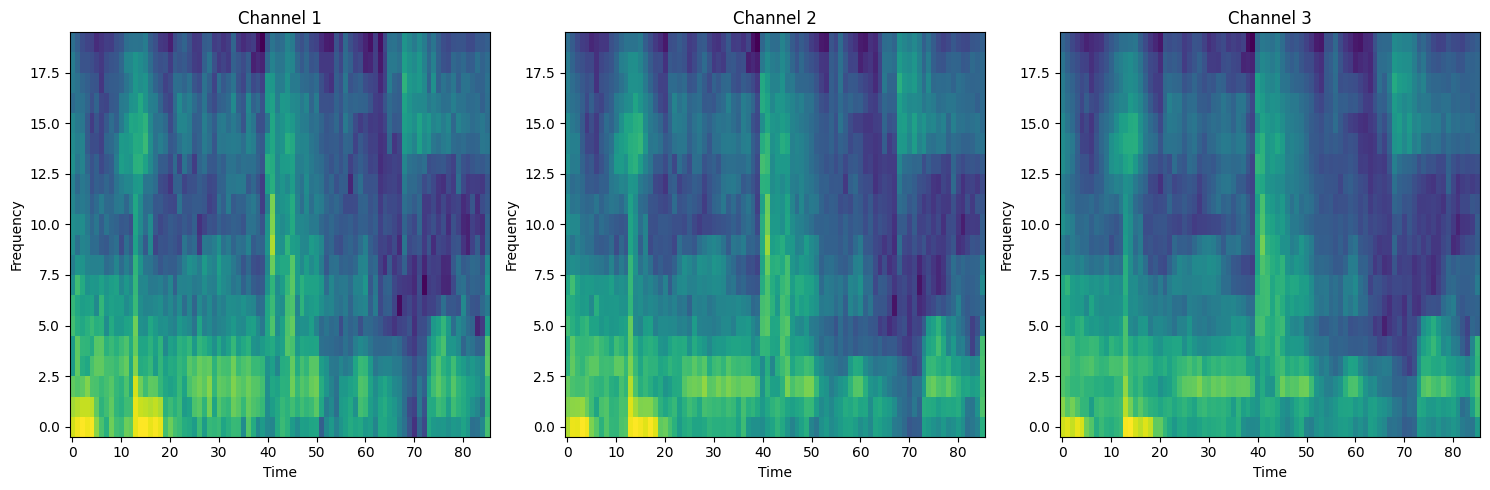

In [247]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded a spectrogram from your dataset
waveform, spectrogram = train_dataset.get_random_music_onset()
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectrogram)

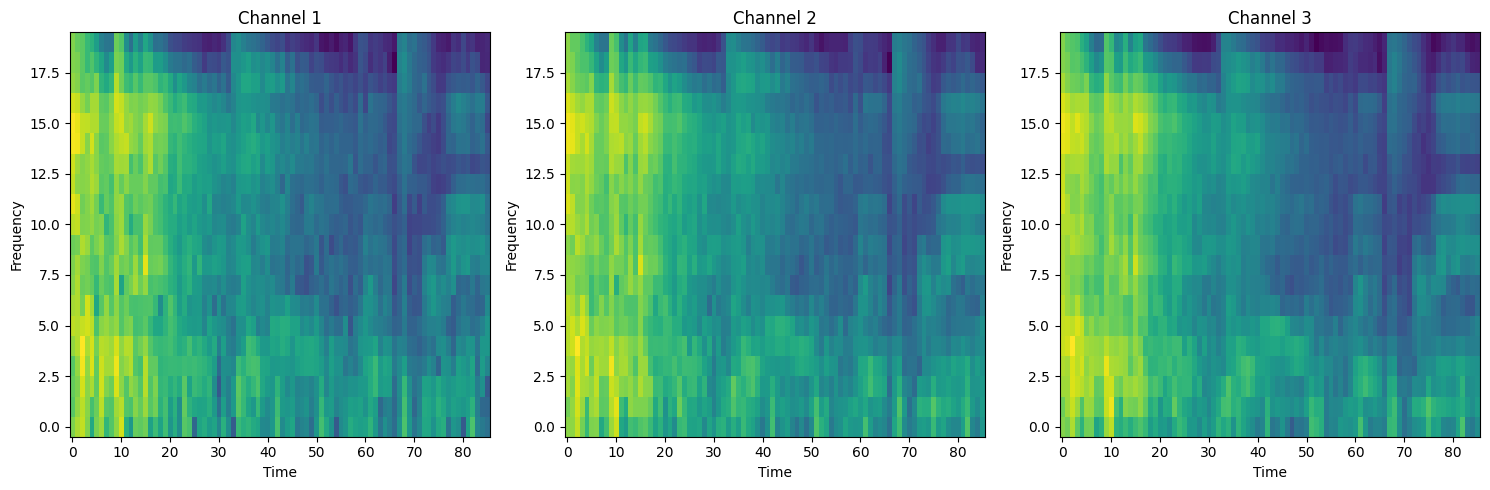

In [248]:
waveform, spectrogram = train_dataset.get_random_music_with_gunshot() 
# plot_spectrogram_rgb(spectrogram)
utils.play_audio(waveform)
utils.plot_spectrogram_channels(spectrogram)

In [249]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
use_cuda = th.cuda.is_available()

mean, std = utils.compute_mean_std(train_loader)
mean = mean.to(device)
std = std.to(device)

Computing mean and std: 100%|██████████| 25/25 [00:01<00:00, 15.01it/s]


Epoch [1] Training: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s, loss=0.504]


Epoch [1], Loss: 0.6056


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Optimal threshold: 0.5492
New best f1: 0.7938, model saved.


Epoch [2] Training: 100%|██████████| 25/25 [00:02<00:00, 12.44it/s, loss=0.407]


Epoch [2], Loss: 0.4342


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Optimal threshold: 0.4375
New best f1: 0.8344, model saved.


Epoch [3] Training: 100%|██████████| 25/25 [00:02<00:00, 11.95it/s, loss=0.215]


Epoch [3], Loss: 0.2957


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Optimal threshold: 0.4808
New best f1: 0.8350, model saved.


Epoch [4] Training: 100%|██████████| 25/25 [00:02<00:00, 11.86it/s, loss=0.149]


Epoch [4], Loss: 0.2291


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Optimal threshold: 0.2616


Epoch [5] Training: 100%|██████████| 25/25 [00:02<00:00, 11.89it/s, loss=0.116] 


Epoch [5], Loss: 0.1790


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Optimal threshold: 0.3483
New best f1: 0.8516, model saved.


Epoch [6] Training: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s, loss=0.23]  


Epoch [6], Loss: 0.1749


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Optimal threshold: 0.2092


Epoch [7] Training: 100%|██████████| 25/25 [00:02<00:00, 11.79it/s, loss=0.105] 


Epoch [7], Loss: 0.1584


Validation: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Optimal threshold: 0.1084


Epoch [8] Training: 100%|██████████| 25/25 [00:02<00:00, 10.84it/s, loss=0.379] 


Epoch [8], Loss: 0.1430


Validation: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Optimal threshold: 0.1088
No improvement in f1 for 3 epochs. Stopping training.


Computing Confusion Matrix: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


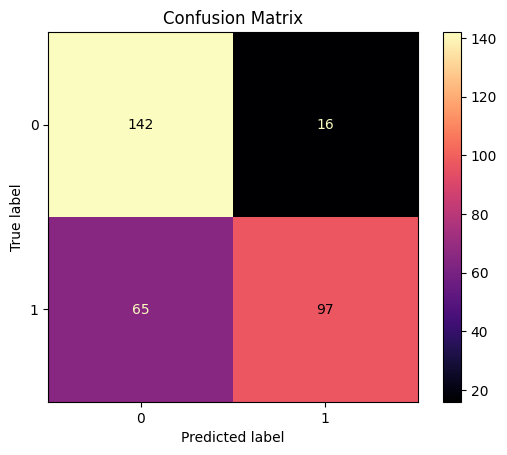

In [250]:
epochs = 10
lr = 3e-4

optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = th.nn.BCELoss()

best_threshold, best_score = utils.train_model(
    model, optimizer, criterion, train_loader, valid_loader, num_epochs=epochs, mean=mean, std=std, patience=3
)

In [230]:
def manual_evaluate_test(model, feature, threshold, frame_size=utils.NUM_FRAMES, sampling_rate=utils.SAMPLING_RATE, hop_length=utils.HOP_LENGTH, mean=None, std=None, step_size=None, filter_time_sec=0):
    """
    Manually evaluate the model on an audio feature, returning time positions where gunshots are detected.

    Parameters:
        model: The trained model.
        feature: The feature (e.g., spectrogram) to evaluate.
        threshold: The prediction threshold for gunshots.
        frame_size: Number of frames to use in each evaluation.
        sampling_rate: Audio sampling rate.
        hop_length: Hop length in samples for each frame.
        mean: Mean for normalization.
        std: Standard deviation for normalization.
        step_size: Step size for moving through frames (default: frame_size // 2).
        filter_time_sec: Time (in seconds) to filter out close consecutive predictions.
    
    Returns:
        List of tuples (minutes, seconds, output) where gunshots are detected along with the model's output.
    """
    if mean is None or std is None:
        raise ValueError("Mean and std must be provided for normalization.")

    mean = mean.to(device)
    std = std.to(device)
    model = model.to(device)
    model.eval()

    predictions = []

    feature = feature.to(device)
    feature = (feature - mean) / std

    num_frames = feature.shape[2]

    if step_size is None:
        step_size = 1

    total_iterations = 0

    with th.no_grad():
        for j in range(0, num_frames - frame_size + 1, step_size):
            total_iterations += 1
            start = j
            end = j + frame_size

            input_frame = feature[:, :, start:end].unsqueeze(0).float()
            output = model(input_frame).squeeze().item()
            predictions.append((output, start))

        print("Number of predictions", len(predictions))

        res = []
        for output, start in predictions:
            if output >= threshold:
                time_in_seconds = start * hop_length / sampling_rate
                minutes = int(time_in_seconds // 60)
                seconds = time_in_seconds % 60
                res.append((minutes, seconds, time_in_seconds, output))

    print(len(res))

    filtered_res = []
    last_detection_time = -float('inf')

    for minutes, seconds, time_in_seconds, output in res:
        if time_in_seconds - last_detection_time >= filter_time_sec:
            filtered_res.append((minutes, seconds, output))
            last_detection_time = time_in_seconds

    return filtered_res

In [233]:
audio_path = '/Users/borosabel/Documents/Uni/Thesis/50 Cent - Many Men (Wish Death) (Dirty Version).mp3'
spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/test_data_wav/Big L - Lifestylez Ov Da Poor And Dangerous.wav'])
# spectrograms, sample_rates = utils.preprocess_audio(['/Users/borosabel/Documents/Uni/Thesis/M.I.A. - Paper Planes.mp3'])
# print(f"Got back spectogram in shape: {spectrograms[0].shape} and sample rate: {sample_rates}")

100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


In [234]:
predictions = manual_evaluate_test(model, spectrograms[0], threshold=best_threshold, mean=mean, std=std, step_size=1, filter_time_sec=1)

if(len(predictions) > 0):
    print(f"Current treshold is {best_threshold} \n")

    for minutes, seconds, output in predictions:
        print(f"Detected gunshot at {minutes}m {seconds:.2f}s with model output: {output:.4f}")
else:
    print("No predictions")

Number of predictions 21418
1851
Current treshold is 0.19201205670833588 

Detected gunshot at 0m 16.85s with model output: 0.1973
Detected gunshot at 0m 18.27s with model output: 0.2890
Detected gunshot at 0m 19.67s with model output: 0.2245
Detected gunshot at 0m 21.04s with model output: 0.2552
Detected gunshot at 0m 22.47s with model output: 0.2407
Detected gunshot at 0m 23.90s with model output: 0.2369
Detected gunshot at 0m 25.31s with model output: 0.2141
Detected gunshot at 0m 26.73s with model output: 0.2539
Detected gunshot at 0m 28.14s with model output: 0.2536
Detected gunshot at 0m 29.50s with model output: 0.2525
Detected gunshot at 0m 30.95s with model output: 0.1989
Detected gunshot at 0m 32.36s with model output: 0.2059
Detected gunshot at 0m 33.79s with model output: 0.2293
Detected gunshot at 0m 35.20s with model output: 0.2692
Detected gunshot at 0m 36.63s with model output: 0.1962
Detected gunshot at 0m 37.79s with model output: 0.1933
Detected gunshot at 0m 38.80s

In [210]:
prediction = utils.process_and_predict(model, audio_path, start_time_sec=66.12, mean=mean, std=std, threshold=best_threshold)

Treshold 0.5936126708984375
Playing the audio sample from 66.12 seconds.


Input #0, wav, from '/var/folders/99/617f3z715_g8nc26tll89ddc0000gn/T/tmp7p104gvn.wav':
  Duration: 00:00:00.99, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s



Model Prediction: Gunshot with output: 0.6831712126731873
